# Solução para predição de diabetes
![DIABETS](https://user-images.githubusercontent.com/32513366/113214255-98e2bc80-924f-11eb-9e89-01510207e43d.png)

Este notebook busca apresentar uma solução um pipeline padrão para solução de problemas de data science e uma explicação rebuscada a respeito de explicação de modelos.

Caso este notebook te ajude, dê um **UPVOTE**!

# Módulos

In [1]:
# Pacotes para instalar
!pip install prince;

In [2]:
# Geral/Dados
import numpy as np
import pandas as pd
from time import sleep

# Graficos
import matplotlib.pyplot as plt
import seaborn as sns

# Valores faltantes
import missingno as msno

# Testes estatísticos
from scipy import stats

# Pre-processamento
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Imputação
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer as MICE

# Seleção de Features
from boruta import BorutaPy

# Modelagem com AI
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as XGBoost
from xgboost.sklearn import XGBClassifier

# Analise de resultados
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Explicabilidade de Modelos/Resultados
import shap
import prince
import eli5
import lime
import lime.lime_tabular

# Para sumir mensagens chatas do pandas (mesmo eu usando .loc)
pd.set_option('mode.chained_assignment', None)
%matplotlib inline

# Funções

In [3]:
def construir_distribuicoes(data, variaveis, objetivo=None, usar_objetivo=False):
    # Definindo figura para construir gráficos
    fig, axes = plt.subplots(nrows=int(len(variaveis)/2), ncols=2, figsize=(20,15))
    
    # Indexadores
    r = 0      # Linha
    c = 0      # Coluna

    # Loop em todas as variaveis
    for v in variaveis:
        # Realizar gráfico de distribuicao
        if usar_objetivo is False:
            sns.kdeplot(data[v], shade=True, color='#50c878', ax=axes[r][c])
        else:
            sns.kdeplot(data.loc[data[objetivo] == 0, v], shade=True, color='#386796', ax=axes[r][c], label='Negative')
            sns.kdeplot(data.loc[data[objetivo] == 1, v], shade=True, color='#F06C61', ax=axes[r][c], label='Positive')
            # Gerar legenda
            axes[r][c].legend(title=objetivo)
            pass
        
        # Aplicar configuracao do gráfico - gerais
        axes[r][c].set_title('Variável - ' + v)   
        axes[r][c].set_xlabel('')
        
        # Controle dos indexadores
        c += 1
        if c > 1:
            c = 0
            r += 1
    
    # Configuracao básica de gráfico
    plt.tight_layout()

In [4]:
def verificar_zero(data, variaveis):
    for v in variaveis:
        print('Variável',v,'possui',sum(data[v] == 0),'valores zerados.')    

In [5]:
def substituir_zero(data, variaveis):
    for v in variaveis:
        data[v].replace({0:np.nan}, inplace=True)
    return data

In [6]:
def grafico_faltantes(data, variaveis, titulo):
    msno.matrix(data[variaveis], sort='ascending')
    plt.title(titulo, weight='bold', size=35)

In [7]:
def crosstab(data, col1, col2):
    return round(100*pd.crosstab(data[col1], data[col2])/len(data), 2)

In [8]:
def calcular_correlacao_numerica(data, variaveis, corr_tipo='spearman'):
    return data[variaveis].corr(corr_tipo)

In [9]:
def fazer_mapa_calor_corr(corr_matrix, titulo):    
    # Fazer mascara para evitar correlação espelho
    mascara = np.triu(corr_matrix)
    # Fazer grafico
    plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
    sns.heatmap(corr_matrix, annot = True, mask=mascara, fmt='.2f', vmin=-1, vmax=1)
    plt.title(titulo, fontsize=25, fontweight='bold')
    plt.tight_layout()    

In [10]:
def fazer_scatter_plot(data, col1, col2, color_by=None):
    # Definir figura
    plt.figure(figsize=(20,10))
    # Escolher de acordo a variável
    if color_by is None:   
        sns.scatterplot(data=data, x=col1, y=col2)
    else:
        sns.scatterplot(data=data, x=col1, y=col2, hue=color_by)

In [11]:
def fazer_kruskal_wallis_test(variavel1, variavel2, alpha=0.05):
    # Realizar teste
    p_valor, kw_res_stats = stats.kruskal(variavel1, variavel2)
    
    # Verificar resultado
    if p_valor > alpha:
        print('Nenhuma diferença significativa entre as distribuições (falhou em rejeitar H0)')
    else:
        print('Distribuições distintas (rejeito H0)')

In [12]:
# Função bem genérica para anotar valores em gráficos
def annotate_bars_value(eixo, coord_texto_xy, barra_eixo_y=True):
    # Loop em cada barra que existe no gráfico
    for barra in eixo.patches:
        if barra_eixo_y:
            tamanho_barra = barra.get_width() # Pegar o tamanho da barra
            texto_barra = str(round(tamanho_barra, 2))+'%'  # Texto que sera anotado referente a barra
            coord_anotacao_xy = (barra.get_x() + tamanho_barra, barra.get_y()) # Coordenada de onde sera a anotacao no grafico
            eixo.annotate(texto_barra, coord_anotacao_xy, xytext=coord_texto_xy, fontsize=12, color='black',
                          textcoords='offset points', horizontalalignment='right')
        else:
            tamanho_barra = barra.get_height() # Pegar o tamanho da barra
            texto_barra = str(round(tamanho_barra, 2))+'%' # Texto que sera anotado referente a barra
            coord_anotacao_xy = (barra.get_x(), barra.get_y() + tamanho_barra) # Coordenada de onde sera a anotacao no grafico
            eixo.annotate(texto_barra, coord_anotacao_xy, xytext=coord_texto_xy, fontsize=12,color='black',
                          textcoords='offset points', horizontalalignment='right')

# Construção de modelo
## Importando os dados

In [13]:
# Base de dados
df = pd.read_csv('../input/pima-indians-diabetes-database/diabetes.csv')

In [14]:
# Definindo grupos de variáveis (features) e objetivo
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
objetivo = 'Outcome'

## Análise exploratória das variáveis I

### (1) Distribuições

Inicialmente vamos visualizar a distribuição das variáveis para identificar alguma anomalia nos dados.

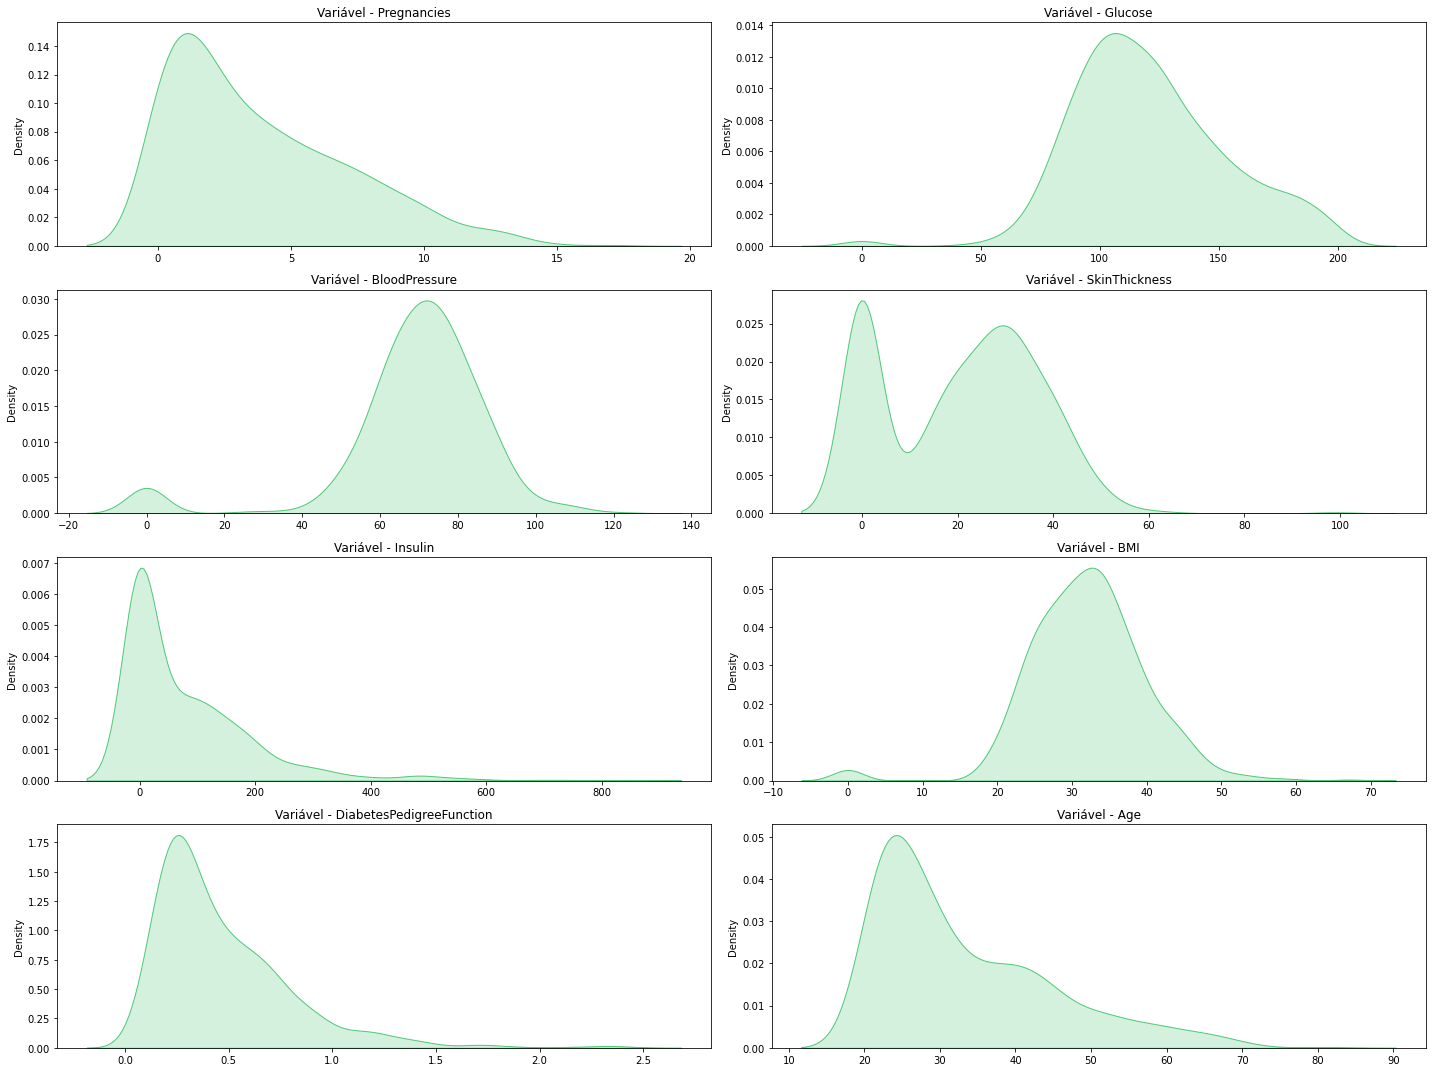

In [15]:
construir_distribuicoes(df, features)

### Conclusões
Podemos verificar inicialmente `Insulin`, `BMI` e `SkinThickness` possuem picos em zero. Vamos buscar as definições teóricas dessas variáveis:
- `Insulin`: É um hormônio secretado pelo pâncreas que controla o nível de glicose no sangue. A insulina funciona como uma chave para a glicose entrar nas células e ser utilizada como fonte de energia.
- `BMI`: O índice de massa corporal é uma medida internacional usada para calcular se uma pessoa está no peso ideal.
- `SkinThickness`: Espessura da pele.

Considerando a definição biológica, essas variáveis não podem ter valor igual a zero, logo o mais provável é que o valor zero neste caso seja valor faltante.

In [16]:
verificar_zero(df, features)

Variável Pregnancies possui 111 valores zerados.
Variável Glucose possui 5 valores zerados.
Variável BloodPressure possui 35 valores zerados.
Variável SkinThickness possui 227 valores zerados.
Variável Insulin possui 374 valores zerados.
Variável BMI possui 11 valores zerados.
Variável DiabetesPedigreeFunction possui 0 valores zerados.
Variável Age possui 0 valores zerados.


Com exceção de `Pregancies`, esses valores zerados devem ser tratados, pois não fazem sentido biológico serem zerados. Porém antes, vamos verificar a mesma distribuição estratificada pela variável objetivo.

### (2) Distribuições estratificadas

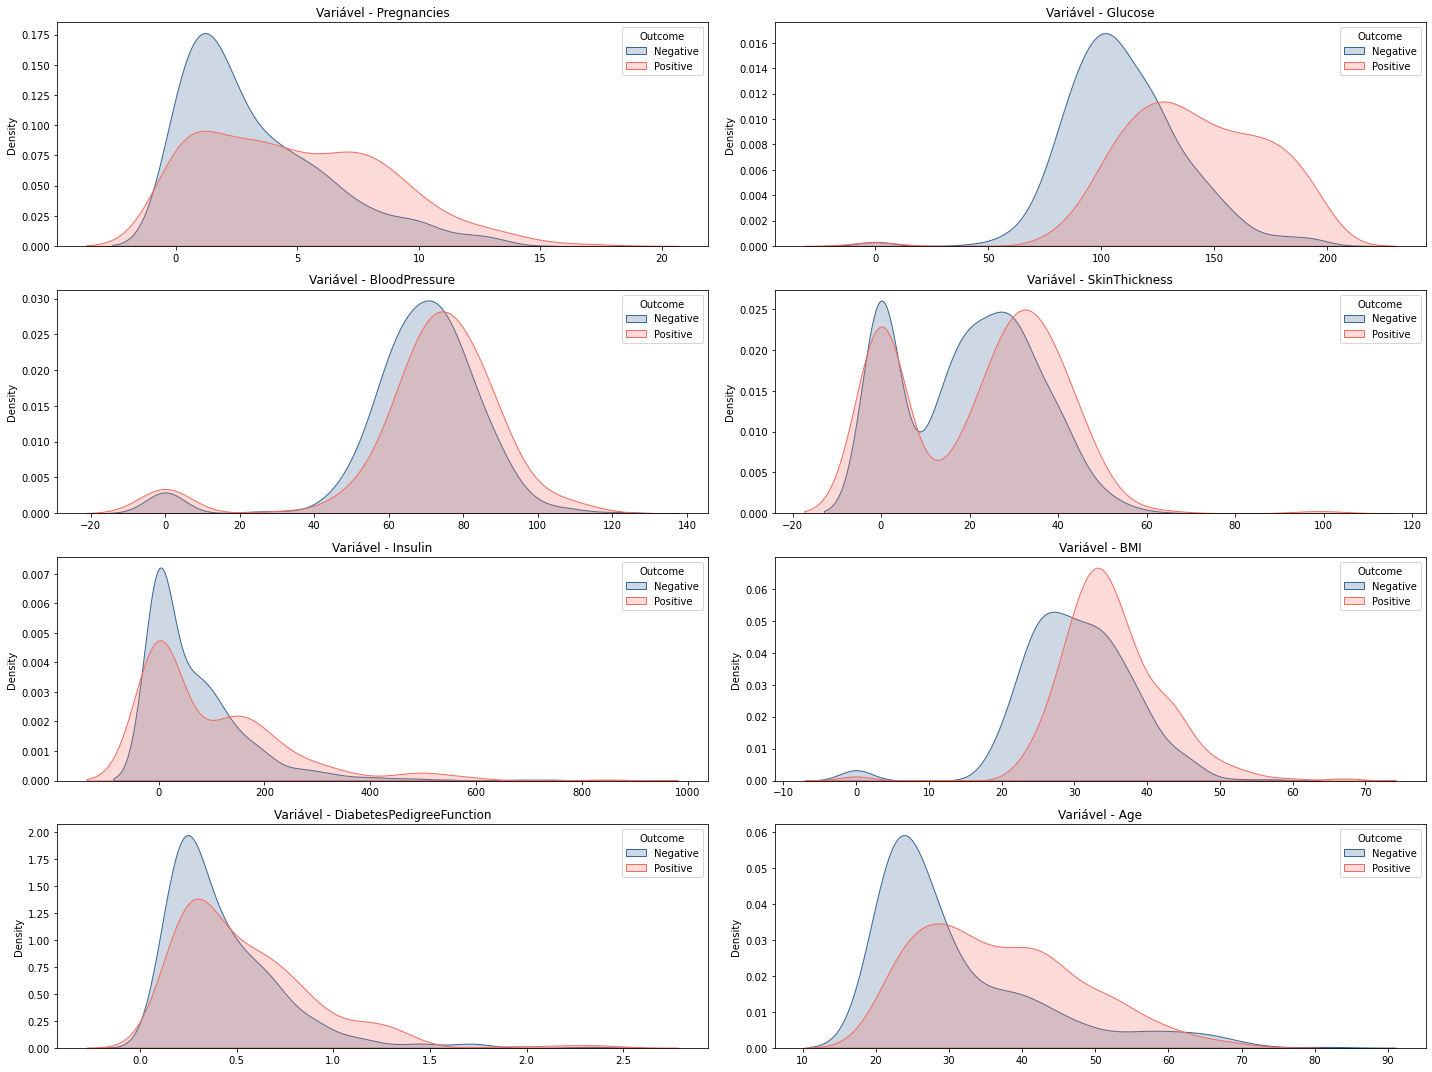

In [17]:
construir_distribuicoes(df, features, objetivo, True)

### Conclusões
Note que para ambas as categorias, os valores de zero estão presentes. Situações interessantes poderiam ter emergidos como os valores zerados estão apenas para uma das categorias, o que indicaria uma boa correlação entre valores faltantes com nosso objeto de predição.

Vamos então solucionar essa questão para então analisar outros fatores referentes a essas variáveis.

In [18]:
# Trocar zeros por valores faltantes
df = substituir_zero(df, features[1:])

### (3) Teste de hipóteses
A ideia desta etapa é avaliar a seguinte hipótese:

**Existe diferença entre a distribuição dos valores de uma variável X para casos positivos e negativos?**

Para as variáveis que confirmarem essa hipótese, podemos esperar que a mesma seja uma boa preditora para o nosso problema.

In [19]:
for v in features:
    # Mostrar nome da variavel
    print('########################################## ',v)
    # Realizar teste e verificar resultado
    fazer_kruskal_wallis_test(df.loc[df[objetivo]==0, v],df.loc[df[objetivo]==1, v])

##########################################  Pregnancies
Nenhuma diferença significativa entre as distribuições (falhou em rejeitar H0)
##########################################  Glucose
Distribuições distintas (rejeito H0)
##########################################  BloodPressure
Distribuições distintas (rejeito H0)
##########################################  SkinThickness
Distribuições distintas (rejeito H0)
##########################################  Insulin
Distribuições distintas (rejeito H0)
##########################################  BMI
Distribuições distintas (rejeito H0)
##########################################  DiabetesPedigreeFunction
Nenhuma diferença significativa entre as distribuições (falhou em rejeitar H0)
##########################################  Age
Nenhuma diferença significativa entre as distribuições (falhou em rejeitar H0)


### Conclusões
Neste caso podemos esperar que `BMI`, `Insulin`, `Glicose` e `SkinThickness` podem ser boas candidatas para predição de variáveis.

## Análise de valores faltantes inicial

Primeiro vamos verificar os valores faltantes distribuidos pela tabela.

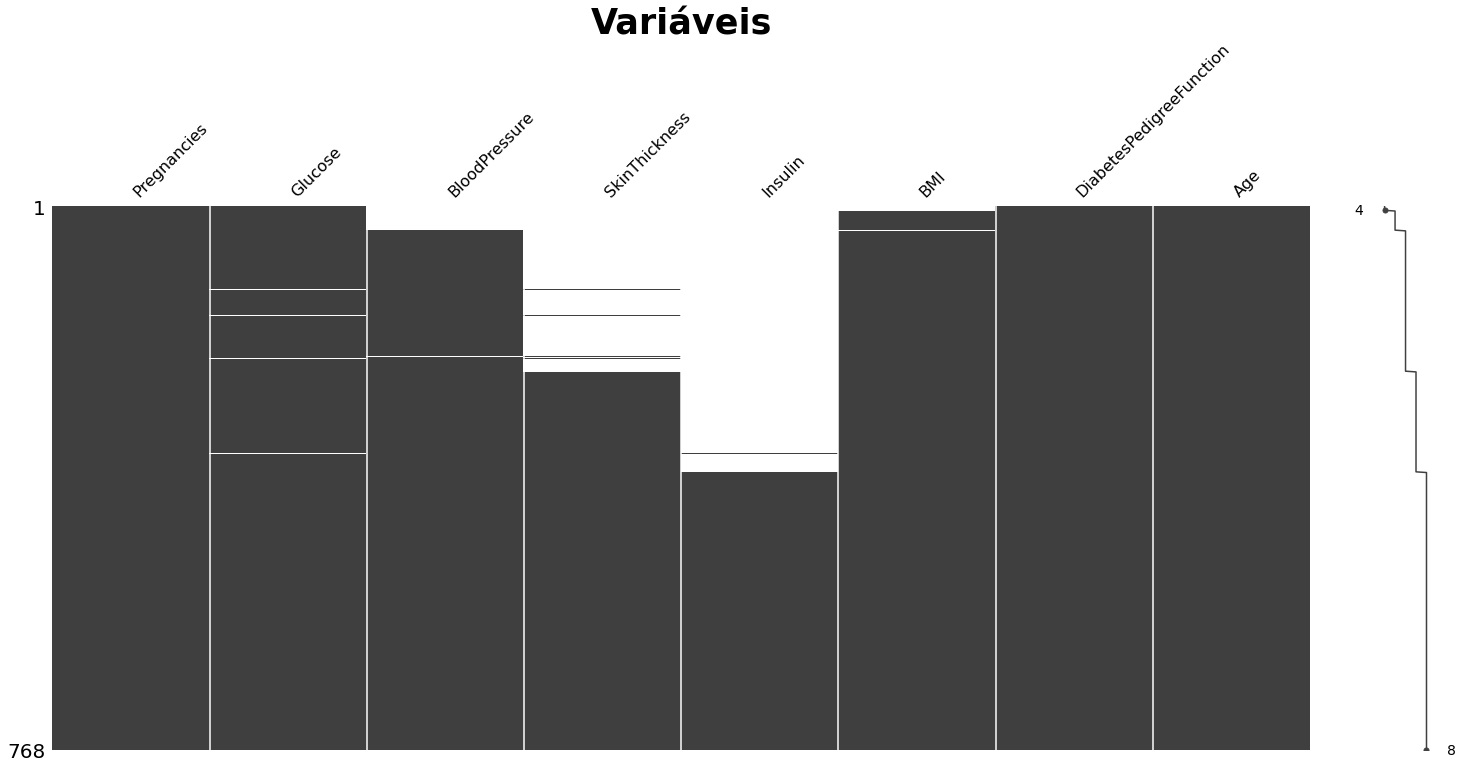

In [20]:
grafico_faltantes(df, features, 'Variáveis')

### Conclusões
Conseguimos ver que as variáveis `Insulin` e `SkinThickness` possuem uma grande quantidade de valores faltantes. Será que isso possui alguma correlação com a variável objetivo?

In [21]:
# Criar variáveis binárias referente aos valores faltantes para colunas mais faltantes
df['NAN_Insulin'] = pd.isnull(df['Insulin']).replace({True:1, False:0})
df['NAN_SkinThickness'] = pd.isnull(df['SkinThickness']).replace({True:1, False:0})

In [22]:
# Verificar crosstab
crosstab(df, 'NAN_Insulin', objetivo)

Outcome,0,1
NAN_Insulin,,
0,34.38,16.93
1,30.73,17.97


In [23]:
# Verificar crosstab
crosstab(df, 'NAN_SkinThickness', objetivo)

Outcome,0,1
NAN_SkinThickness,,
0,47.01,23.44
1,18.10,11.46


### Conclusões

Percebemos que aproximadamente metade dos valores faltantes para a variável `SkinThickness` ocorrem para casos negativos de diabetes. Essa informação pode ser interessante para construção de modelos.

In [24]:
# Verificar proporcao de variavel objetivo
df[objetivo].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [25]:
# Verificar proporcao de variavel objetivo apenas com amostras completas
df.dropna()[objetivo].value_counts()

0    262
1    130
Name: Outcome, dtype: int64

In [26]:
# Criar dataframe de apenas amostras completas
df_full = df.dropna()

### Conclusões
Vamos avaliar algumas correlações usando apenas o conjunto completo de variáveis. Além disso, vamos manter as variáveis referentes à presença de valores faltantes para testar futuramente.

## Análise exploratória das variáveis II

### (1) Correlações de Spearman

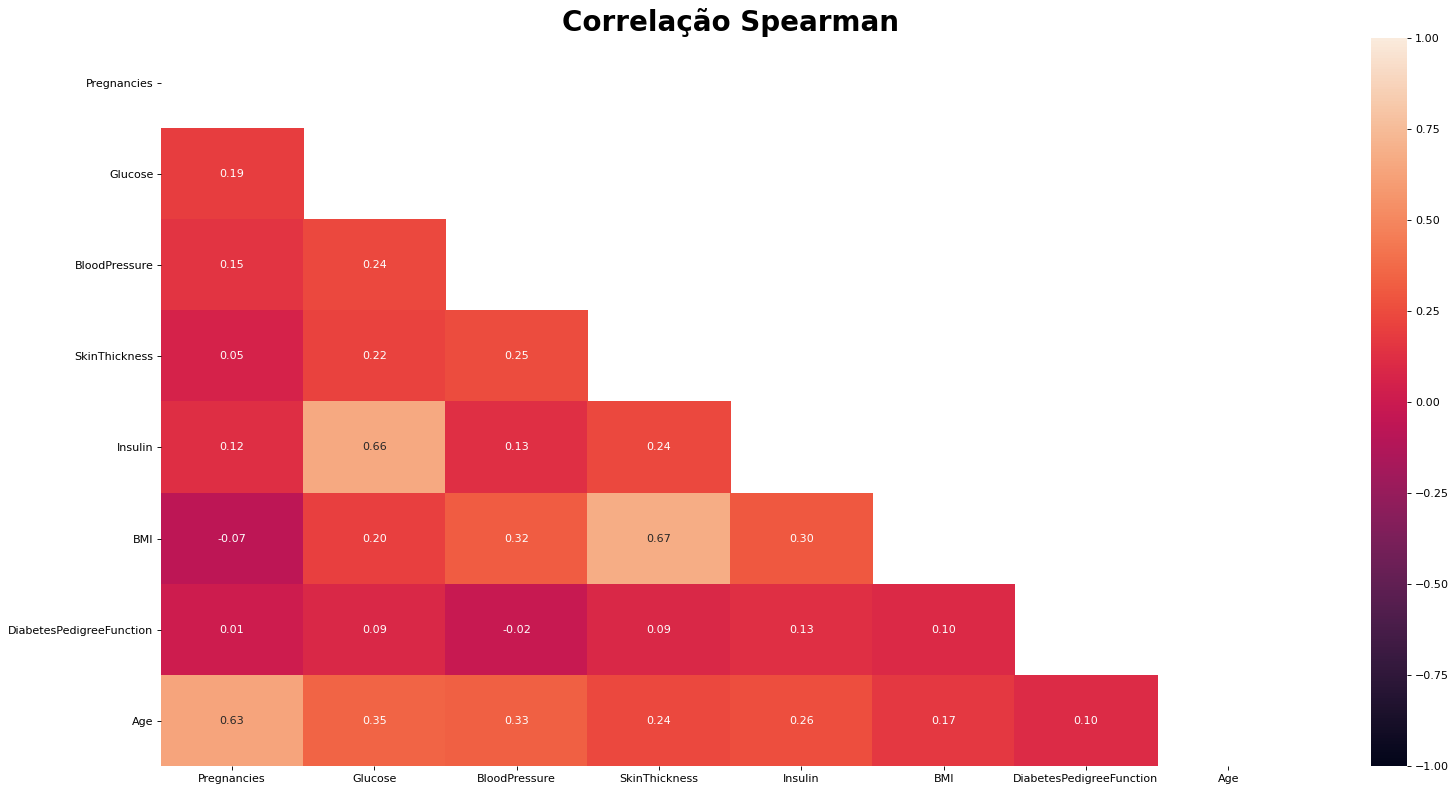

In [27]:
# Calcular correlacao
corr_matrix = calcular_correlacao_numerica(df_full, features, 'spearman')

# Gerar mapa de calor
fazer_mapa_calor_corr(corr_matrix, 'Correlação Spearman')

### Conclusões
Considerando um limite de 0.8 para definir uma correlação forte, vemos que neste caso isto não ocorre. Porém, iremos avaliar alguns gráficos *scatter* para as duplas com correlações acima de 0.6 para entender melhor essas relações.

### (2) Gráficos de *Scatter*

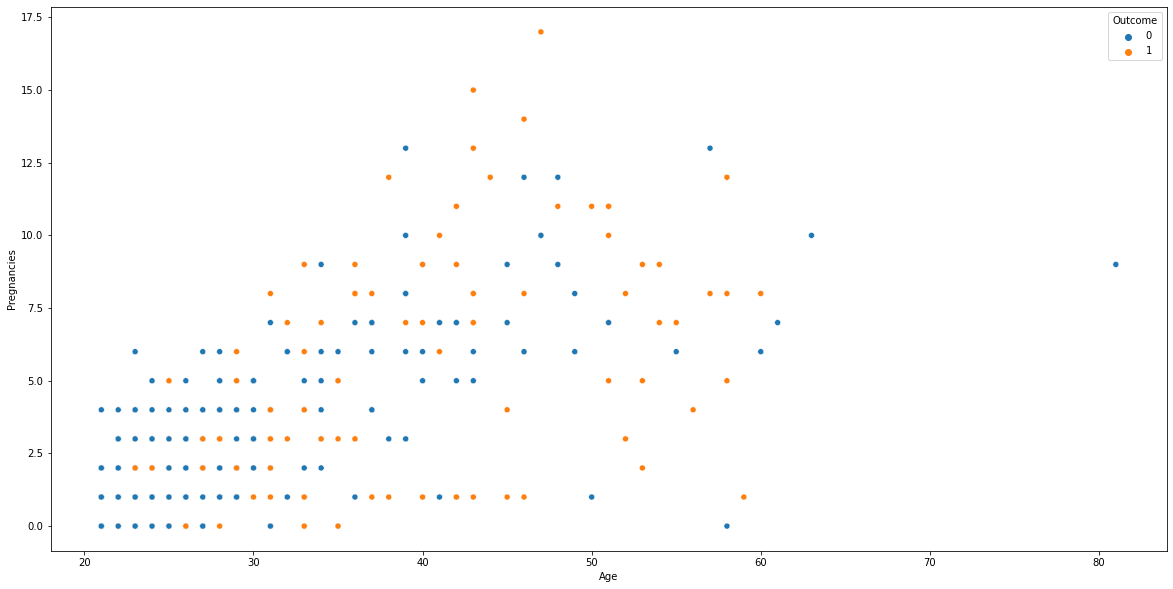

In [28]:
fazer_scatter_plot(df_full, 'Age', 'Pregnancies', objetivo)

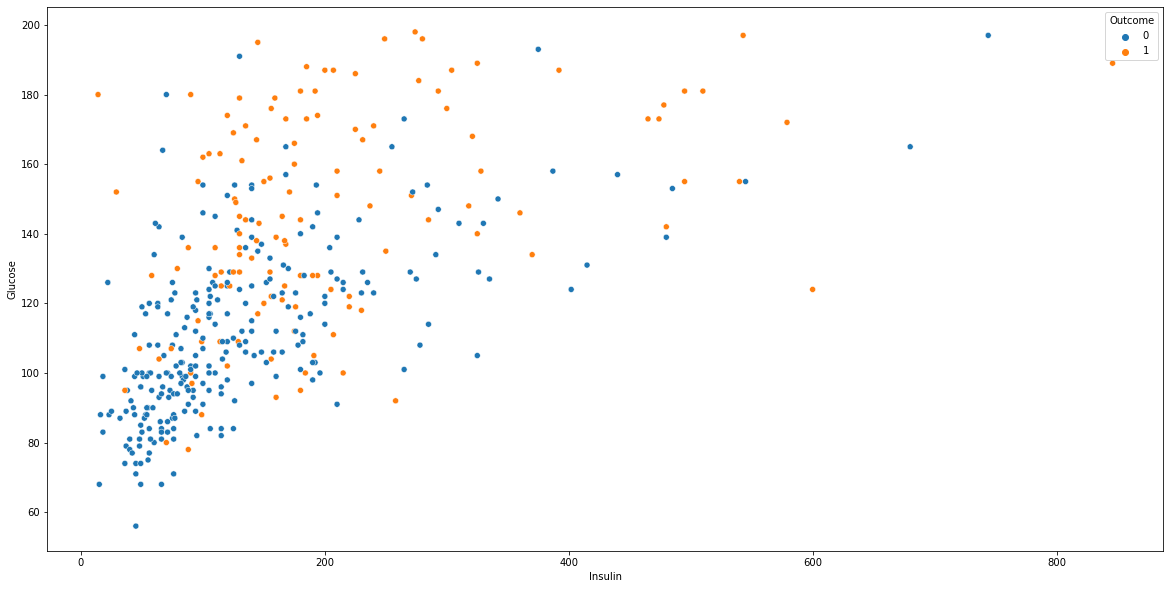

In [29]:
fazer_scatter_plot(df_full, 'Insulin', 'Glucose', objetivo)

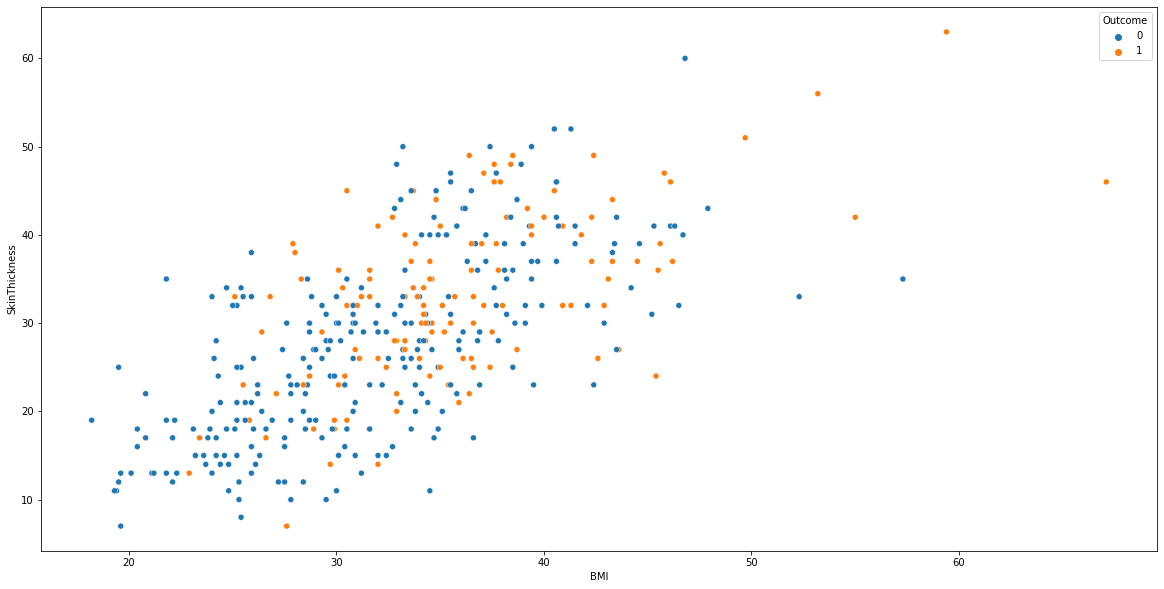

In [30]:
# Age X Pregnancies
fazer_scatter_plot(df_full, 'BMI', 'SkinThickness', objetivo)

### Conclusões

Percebemos que existe uma certa correlação: enquanto uma aumenta a outra aumenta também para todos os casos. Inclusive casos positivos de diabetes pegam valores maiores para as variáveis dos dois últimos gráficos citados.

Porém, como não foi uma correlação forte, iremos mantê-las no conjunto de variáveis.

## Pré-processamento

### (1) Divisão treino-teste

In [31]:
# Definindo conjunto X e Y
x = df.drop(axis=1, columns=[objetivo]).copy()
y = df[objetivo].copy()

In [32]:
# Fazendo a divisão estratificada 80/20
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state=1206, stratify=y)

In [33]:
# Corrigir indexes para X
x_train.reset_index(inplace=True, drop=True)
x_test.reset_index(inplace=True, drop=True)

In [34]:
# Corrigir indexes para Y
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [35]:
# Verificando conjunto de treino das features
x_train.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NAN_Insulin,NAN_SkinThickness
0,0,146.0,70.0,NaN,NaN,37.9,0.334,28,1,1
1,2,158.0,90.0,NaN,NaN,31.6,0.805,66,1,1
2,1,100.0,72.0,12.0,70.0,25.3,0.658,28,0,0
3,0,138.0,60.0,35.0,167.0,34.6,0.534,21,0,0
4,0,128.0,68.0,19.0,180.0,30.5,1.391,25,0,0


### Conclusões

Note que deixei as variáveis referente as presenças de valores faltantes. A ideia é avaliar através de uma seleção de features se essas variáveis podem ser boas preditoras.

### (2) Transformações
Para variáveis inteiras vamos utilizar `MinMax` e para *floats* vamos utilizar `StandardScaler`. Para binárias não será feito nada.

In [36]:
# Definindo subgrupos de features
features_int = ['Pregnancies', 'Age']
features_flo = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
features_bin = ['NAN_Insulin', 'NAN_SkinThickness']

In [37]:
# Criar objetos de transformação
transf_mm = MinMaxScaler()
transf_ss = StandardScaler()

In [38]:
# Aplicar transformação para inteiras
x_train.loc[:,features_int] = transf_mm.fit_transform(x_train.loc[:,features_int]).round(3)
x_test.loc[:,features_int] = transf_mm.transform(x_test.loc[:,features_int]).round(3)

In [39]:
# Aplicar transformação para floats
x_train.loc[:,features_flo] = transf_mm.fit_transform(x_train.loc[:,features_flo]).round(3)
x_test.loc[:,features_flo] = transf_mm.transform(x_test.loc[:,features_flo]).round(3)

In [40]:
# Visualizando conjunto de treino
x_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NAN_Insulin,NAN_SkinThickness
0,0.000,0.658,0.469,NaN,NaN,0.504,0.111,0.117,1,1
1,0.133,0.735,0.673,NaN,NaN,0.343,0.321,0.750,1,1
2,0.067,0.361,0.490,0.054,0.066,0.182,0.256,0.117,0,0
3,0.000,0.606,0.367,0.304,0.183,0.419,0.200,0.000,0,0
4,0.000,0.542,0.449,0.130,0.199,0.315,0.582,0.067,0,0


In [41]:
# Visualizando o balanceamento da variável objetivo para conjunto de treino
y_train.value_counts()

0    400
1    214
Name: Outcome, dtype: int64

### (3) Imputação de Dados

Para isso, vou desconsiderar toda a **análise necessária para realizar uma imputação de qualidade**. Caso queira saber mais os requisitos para uma imputação, acesse este [notebook](https://www.kaggle.com/kaikewreis/a-second-end-to-end-solution-for-covid-19#Impute-or-Not-Impute?-that-is-the-question) na seção de imputação.

In [42]:
# Definir objeto de imputação
imputer = MICE(max_iter=10000, verbose=1, random_state=1206)

In [43]:
# Realizar imputação no conjunto de treino
x_train = pd.DataFrame(imputer.fit_transform(x_train.values), columns=x_train.columns)

[IterativeImputer] Completing matrix with shape (614, 10)
[IterativeImputer] Change: 0.4251210650321795, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.04308241399622485, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.020480194789260817, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.009672295255613056, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.004565374079132045, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.0021548369814195223, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.0010170609256258817, scaled tolerance: 0.001 
[IterativeImputer] Change: 0.0004800378760672075, scaled tolerance: 0.001 
[IterativeImputer] Early stopping criterion reached.


In [44]:
# Realizar imputação no conjunto de teste
x_test = pd.DataFrame(imputer.transform(x_test.values), columns=x_test.columns)

[IterativeImputer] Completing matrix with shape (154, 10)


### Conclusões
Imputação realizada com sucesso em um conjunto desbalanceado.

### (4) *Oversampling*
Neste trabalho, vamos optar por realizar a aplicação de uma técnica para remover o desbalanceamento no conjunto de treinamento. Essa parte poderia ser ignorada (trata-se de uma decisão do cientista de dados). Irei realiza-la, dado os bons resultados que já obtive com este método e para evitar o treinamento com uma base desbalanceada.

In [45]:
# Criar objeto de SMOTE
smt = SMOTE(k_neighbors=5, random_state=1206)

In [46]:
# Realizar processo de oversampling
x_train, y_train = smt.fit_resample(x_train, y_train)

In [47]:
# Verificar balanceamento da classe objetivo
y_train.value_counts()

0    400
1    400
Name: Outcome, dtype: int64

### Conclusões
Base de treinamento balanceada, vamos selecionar as variáveis para construir o modelo.

## Seleção de Features

Para isso vamos usar o método **Boruta**.

In [48]:
# Definir um estimador para o método
rfe = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_features='log2', max_depth=5)

# Definir parametros do método boruta
feat_selector = BorutaPy(rfe, n_estimators='auto', verbose=0, random_state=1206, max_iter=100)

In [49]:
# Buscar boas preditoras
feat_selector.fit(x_train.values, y_train.values.ravel());

In [50]:
# Verificar variáveis selecionadas
list(x_train.columns[feat_selector.support_])

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [51]:
# Verificar não variáveis selecionadas
[i for i in x_train.columns if i not in list(x_train.columns[feat_selector.support_])]

['NAN_Insulin', 'NAN_SkinThickness']

In [52]:
# Definir apenas as variáveis selecionadas para conjunto de treino
x_train = x_train[list(x_train.columns[feat_selector.support_])]

In [53]:
# Definir apenas as variáveis selecionadas para conjunto de teste
x_test = x_test[list(x_test.columns[feat_selector.support_])]

### Conclusões
Podemos verificar que nenhuma das colunas criadas a partir de valores faltantes passaram neste filtro. Nenhuma das variáveis que perderam no teste foi eliminada aqui. Ao final, todas as variáveis são elegíveis para construção de modelo.

## Construção de modelos
Iremos utilizar *RandomSearch* para buscar os melhores hiper parâmetros.

### Funções específicas

In [54]:
def mostrarResultadosFinaisOtimizacao(modelo, hp, score, metrica_avaliada):
    print('Model:', type(modelo).__name__)
    print('Metric: ', metrica_avaliada, ' | Score (%): ', 100*round(score,5))
    print('Best Parameters: ', hp)

In [55]:
def optimizacaoHP(modelo, params, metrica, cv_gerador, n_iter, features, objetivo):
    # Definir Objeto de busca com Bayes Optmization
    hp_search = RandomizedSearchCV(estimator=modelo,
                                   param_distributions=params, 
                                   n_iter=n_iter,
                                   cv=cv_gerador,
                                   scoring=metrica,
                                   verbose=0,
                                   random_state=1206,
                                   n_jobs=-1)
    # Buscar
    hp_search.fit(features, objetivo)
    # Retornar resultado
    return (hp_search.best_estimator_, hp_search.best_params_, hp_search.best_score_, hp_search.cv_results_)

In [56]:
def PipelineDeOtimizacaoHP(modelo,params,x_train,y_train,metrica,cv_gerador,n_iter=1000):
    # 1 - Buscar
    best_model,best_params,best_score,cv_results = optimizacaoHP(modelo,params,metrica,cv_gerador,n_iter,x_train,y_train)
    # Aguardar ...
    sleep(1.5)    
    # 2 - Mostrar resultados finais
    mostrarResultadosFinaisOtimizacao(best_model, best_params, best_score, metrica)
    # 3 - Retornar resultados
    returned_dict = {'best_model':best_model,'best_params':best_params,'best_score':best_score,
                     'cv_res':pd.DataFrame(cv_results),'metric_used':metrica}
    return returned_dict

### (1) Construção dos modelos

In [57]:
# Objeto de validação cruzada (manter divisao padrão para todos os tipos de modelo)
strat_cv_folds = StratifiedKFold(n_splits=5, random_state=101, shuffle=True)
# Metrica para otimizar
metrica = 'roc_auc'

### Regressão Logística

In [58]:
# Define estimador
estimador = LogisticRegression(random_state=1206,penalty='elasticnet', solver='saga', max_iter=5000)

# Define parametros de busca (grid)
params = {'C': [0.001, 0.01, 0.025, 0.1, 1, 5, 10],
          'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'class_weight': ['balanced',None]}

# Otimizar
lre = PipelineDeOtimizacaoHP(estimador, params, x_train, y_train, metrica, strat_cv_folds, 100)

Model: LogisticRegression
Metric:  roc_auc  | Score (%):  84.856
Best Parameters:  {'l1_ratio': 0.6, 'class_weight': None, 'C': 5}


### Random Forest

In [59]:
# Define estimador
estimador = RandomForestClassifier(random_state=1206, criterion='gini')

# Define parametros de busca (grid)
params = {'n_estimators': [100, 250, 500, 1000],
          'max_depth': [2, 4, 8, 16, 32],
          'min_samples_split': [2, 4, 8, 10, 16],
          'min_samples_leaf': [1, 3, 4, 6, 8],
          'class_weight': ['balanced','balanced_subsample',None],
          'max_features': ['sqrt','log2']}
# Otimizar
rfc = PipelineDeOtimizacaoHP(estimador, params, x_train, y_train, metrica, strat_cv_folds, 100)

Model: RandomForestClassifier
Metric:  roc_auc  | Score (%):  89.942
Best Parameters:  {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 16, 'class_weight': 'balanced_subsample'}


### Boosting Gradient

In [60]:
# Define estimador
estimador = GradientBoostingClassifier(random_state=1206, loss='deviance', criterion='friedman_mse')

# Define parametros de busca (grid)
params = {'n_estimators': [100, 250, 500, 1000],
          'min_samples_leaf': [1, 3, 4, 6, 8],
          'min_samples_split': [2, 4, 8, 10, 16],
          'max_depth': [2, 4, 8, 16, 32],
          'subsample': [0.75, 0.80, 0.85, 0.9, 0.95, 1.0],
          'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
          'max_features': ['sqrt','log2']}

# Otimizar
bst = PipelineDeOtimizacaoHP(estimador, params, x_train, y_train, metrica, strat_cv_folds, 100)

Model: GradientBoostingClassifier
Metric:  roc_auc  | Score (%):  90.472
Best Parameters:  {'subsample': 0.75, 'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 32, 'learning_rate': 0.05}


### Conclusões
De acordo a métrica escolhida, o melhor modelo foi a **random forest**. Porém vamos avaliar estes modelos no conjunto de teste.


## Analise de resultados finais em conjunto de teste

### Regressão Logística

In [61]:
# Fazer predicao
y_pred = lre['best_model'].predict(x_test)

# Mostrar Classification Report
print(classification_report(y_test, y_pred))

# Mostrar Matriz de confusão
pd.DataFrame(confusion_matrix(y_test, y_pred, labels=np.unique(y_test)), index=['Real - 0', 'Real - 1'], columns=['Predito - 0', 'Predito - 1'])

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       100
           1       0.66      0.78      0.71        54

    accuracy                           0.78       154
   macro avg       0.76      0.78      0.77       154
weighted avg       0.79      0.78      0.78       154



,Predito - 0,Predito - 1
Real - 0,78,22
Real - 1,12,42


### Random Forest

In [62]:
# Fazer predicao
y_pred = rfc['best_model'].predict(x_test)

# Mostrar Classification Report
print(classification_report(y_test, y_pred))

# Mostrar Matriz de confusão
pd.DataFrame(confusion_matrix(y_test, y_pred, labels=np.unique(y_test)), index=['Real - 0', 'Real - 1'], columns=['Predito - 0', 'Predito - 1'])

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       100
           1       0.64      0.72      0.68        54

    accuracy                           0.76       154
   macro avg       0.74      0.75      0.74       154
weighted avg       0.77      0.76      0.76       154



,Predito - 0,Predito - 1
Real - 0,78,22
Real - 1,15,39


### Boosting

In [63]:
# Fazer predicao
y_pred = bst['best_model'].predict(x_test)

# Mostrar Classification Report
print(classification_report(y_test, y_pred))

# Mostrar Matriz de confusão
pd.DataFrame(confusion_matrix(y_test, y_pred, labels=np.unique(y_test)), index=['Real - 0', 'Real - 1'], columns=['Predito - 0', 'Predito - 1'])

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       100
           1       0.64      0.65      0.64        54

    accuracy                           0.75       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154



,Predito - 0,Predito - 1
Real - 0,80,20
Real - 1,19,35


### Conclusões
Avaliando estes resultados no momento, percebemos que o modelo de **Random Forest** como o melhor preditor.

In [64]:
# melhor modelo selecionado
model = rfc['best_model']

# Interpretação de Modelo I - SHAP

![shapLogo](https://user-images.githubusercontent.com/32513366/112763297-3e8cf600-8fda-11eb-998a-ec470e168b77.png)

**SH**apley **A**dditive ex**P**lanations (SHAP) é um método relativamente recente (menos de 10 anos) que busca explicar as decisões dos modelos de inteligência artificial de uma forma mais direta e intuitiva, fugindo de soluções "caixa preta".

Seu conceito é baseado na teoria dos jogos com uma matemática bem robusta. Porém, para utilizar esta metodologia no nosso dia a dia de cientista de dados, não é necessário o seu completo entendimento. Para quem deseja aprender de forma mais profunda como é construída a teoria recomendo a leitura desta [publicação](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d).

Para este notebook, irei buscar demonstrar interpretações mais práticas sobre o SHAP assim como compreender seus resultados.

Para construção de toda esta análise, foi utilizada a biblioteca [shap](https://github.com/slundberg/shap), mantida inicialmente pelo autor do artigo que originou o método e pela comunidade.

Primeiramente vamos calcular os valores SHAP:


In [65]:
# Cálculo do SHAP - Definindo explainer com características desejadas
explainer = shap.TreeExplainer(model=model)

In [66]:
# Cálculo do SHAP
shap_values_train = explainer.shap_values(x_train, y_train)

Note que eu defini um `TreeExplainer`. Isso ocorreu, pois o meu modelo é um modelo baseado em árvore, logo a biblioteca possui um *explainer* específico para. Além disso, até o momento o que fizemos foi:
- Definir um *explainer* com os parâmetros desejados (existem uma diversidade de parâmetros para `TreeExplainer`, recomendo checar futuramente)
- Calcular os valores SHAP para o conjuntos de treino

## O que são os valores SHAP?

Com o conjunto de valores SHAP já definidos para o nosso conjunto de treinamento, podemos avaliar como cada valor de cada variável influenciou no resultado alcançado pelo modelo preditivo.

Em nosso caso, estaremos avaliando os resultados dos modelos em termos de probabilidade, ou seja, a porcentagem X que o modelo apresentou para dizer se a classe correta é 0 ou 1.

Vale ressaltar que isso pode variar de modelo para modelo: Caso você use um modelo XGBoost, provavelmente seu resultado padrão não será em termos de probabilidade como é o da random forest do pacote sklearn. Para tornar o valor em termos de probabilidade você pode defini-lo através do `TreeExplainer`.

Mas chega de papo e vamos lá: **Como posso interpretar os valores de SHAP**?

In [67]:
# Vamos calcular o resultado de probabilidade de predição do conjunto de treino
y_pred_train_proba = model.predict_proba(x_train)

In [68]:
# Vamos agora selecionar um resultado que previu como positivo
print('Probabilidade do modelo prever negativo -',100*y_pred_train_proba[3][0].round(2),'%.')
print('Probabilidade do modelo prever positivo -',100*y_pred_train_proba[3][1].round(2),'%.')

Probabilidade do modelo prever negativo - 17.0 %.
Probabilidade do modelo prever positivo - 83.0 %.


Vamos visualizar os valores de SHAP para aquela amostra de acordo as classes possíveis (0 e 1):

In [69]:
# Valores de SHAP para essa amostra na classe positiva
shap_values_train[1][3]

array([-0.01811709,  0.0807582 ,  0.01562981,  0.10591462,  0.11167778,
        0.09126282,  0.05179034, -0.10822825])

In [70]:
# Valores de SHAP para essa amostra na classe negativa
shap_values_train[0][3]

array([ 0.01811709, -0.0807582 , -0.01562981, -0.10591462, -0.11167778,
       -0.09126282, -0.05179034,  0.10822825])

Bom, até o momento para ser um vetor de números estranhos não é?

Porém, se você olhar com mais calma vai perceber que os valores são iguais em módulo! O que diferencia é o sinal sendo negativo ou positivo.

Se a gente realizar a soma desses vetores, o que iremos encontrar?

In [71]:
# Somatório do valor SHAP - Classe positiva
shap_values_train[1][3].sum().round(2)

0.33

In [72]:
# Somatório do valor SHAP - Classe positiva
shap_values_train[0][3].sum().round(2)

-0.33

Como havia dito, os valores se diferenciam de acordo ao sinal. Podemos dizer que os valores SHAP para classe positiva são o espelho da classe negativa.

Segura esse resultado na sua memória DDR3 que vamos avaliar outro fator importante para nos ajudar a entender os valores SHAP: **O valor de base**.

O valor de base é extraído do próprio explainer e de modo geral, consiste no limite de predição do seu modelo para ele escolher uma classe como correta. 

A classificação binária (nosso caso) apresenta este valor de forma intuitiva: Caso nosso modelo tenha uma probabilidade maior que 50% para uma classe X, então ele irá dizer que aquela amostra deve ser classificada como tal, pois ela tem sua maior confiança naquela classe.

Caso fosse uma situação com três classes para prever, o valor de base seria 33%. Note que isso não significa que apenas uma confiança acima de 33% iria garantir que modelo selecione aquela classe, mas o modelo precisa ter a maioria do **e** ser acima de 33%.

Vamos pegar os valores de base do nosso `Explainer`:

In [73]:
# Adquirir valor de base de classificação do modelo
expected_value = explainer.expected_value

# Apresentar em tela
print('Valor de base para classe negativa -',100*expected_value[0].round(2))
print('Valor de base para classe positiva -',100*expected_value[1].round(2))

Valor de base para classe negativa - 50.0
Valor de base para classe positiva - 50.0


Note que para ambas as classes, o valor de base é igual afinal este é o valor mínimo necessário para um modelo definir aquela classe como correta. Nenhum modelo de classificação binária escolheria (por padrão) que a classe com 49% seria correta em comparação com a classe que possui 51%.

**OBS**: Vale ressaltar que é possível o cientista de dados mudar esses valores de base nos modelos para garantir que uma classe tenha mais força para ser prevista. Essa tática pode ser usada por exemplo em problemas de imbalanceamento onde você precisa dar algum tipo de vantagem para classe minoritária ser prevista com sucesso. Porém, considerando o formato padrão, o valor de base em termos probabilísticos é definido como 100% dividido pela quantidade de categorias.

Finalmente, o somatório dos valores SHAP para uma amostra é definido como:
![shapForm](https://user-images.githubusercontent.com/32513366/112762502-5793a800-8fd6-11eb-9bbb-dca6b3fb4896.png)

Onde *i* é referente a categoria que aqueles valores representam (em nosso caso, categoria 0 ou 1).

Vamos verificar isso em código:

In [74]:
# Somatório dos valores SHAP para classe positiva
print('Somatório SHAP para classe negativa nesta amostra:',100*y_pred_train_proba[3][0].round(2)-100*expected_value[0].round(2))
print('Somatório SHAP para classe positiva nesta amostra:',100*y_pred_train_proba[3][1].round(2)-100*expected_value[1].round(2))

Somatório SHAP para classe negativa nesta amostra: -33.0
Somatório SHAP para classe positiva nesta amostra: 33.0


Note que os valores SHAP bateram com o resultado apresentado anteriormente. **Mas e os valores SHAP individualmente, o que eles representam?**

Para isso vamos usar mais código, usando como referência classe positiva:

In [75]:
for col, vShap in zip(x_train.columns, shap_values_train[1][3]):
    print('###################', col)
    print('Valor SHAP associado:',100*vShap.round(2))

################### Pregnancies
Valor SHAP associado: -2.0
################### Glucose
Valor SHAP associado: 8.0
################### BloodPressure
Valor SHAP associado: 2.0
################### SkinThickness
Valor SHAP associado: 11.0
################### Insulin
Valor SHAP associado: 11.0
################### BMI
Valor SHAP associado: 9.0
################### DiabetesPedigreeFunction
Valor SHAP associado: 5.0
################### Age
Valor SHAP associado: -11.0


Aqui avaliamos para a amostra 3 os valores SHAP referentes a classe positiva. **Valores SHAP positivos como da Glucose, BloodPressure, SkinThickness, BMI e DiabetesPedigreeFunction influenciaram o modelo à prever a classe positiva como correta.** Ou seja, valores positivos implicam uma tendência para a categoria de referência.

Já os valores negativos como Age e Pregnancies, eles buscam indicar que a classe verdadeira é a negativa (a oposta). Neste exemplo, se ambas fossem também positivas o nosso modelo resultaria em uma predição de 100% para a classe positiva, porém como isso não aconteceu eles representam o 17% que é contra a escolha da classe positiva.

Em resumo, você pode pensar no SHAP em contribuições para o modelo definir entre uma das classes. Assim:
- Neste caso, o somatório dos valores SHAP não podem ultrapassar de 50%
- Valores positivos considerando uma classe de referência indicam ser favoráveis aquela classe na predição.
- Valores negativos indicam que a classe correta não é aquela de referência, mas sim outra classe.

Além disso, podemos quantificar em termos de porcentagem a contribuição de cada variável a resposta final daquele modelo divindindo pelo máximo de contribuição possível que neste caso é 50%:

In [76]:
for col, vShap in zip(x_train.columns, shap_values_train[1][3]):
    print('###################', col)
    print('Valor SHAP associado:',100*(100*vShap.round(2)/50).round(2),'%')

################### Pregnancies
Valor SHAP associado: -4.0 %
################### Glucose
Valor SHAP associado: 16.0 %
################### BloodPressure
Valor SHAP associado: 4.0 %
################### SkinThickness
Valor SHAP associado: 22.0 %
################### Insulin
Valor SHAP associado: 22.0 %
################### BMI
Valor SHAP associado: 18.0 %
################### DiabetesPedigreeFunction
Valor SHAP associado: 10.0 %
################### Age
Valor SHAP associado: -22.0 %


Aqui conseguimos verificar que **Insulin** e **SkinThickness** e **BMI** tiveram juntas uma influência de 62%. Podemos perceber também que a variável Age consegue anular o impacto de SkinThickness ou Insulin neste amostra.

## Visualização geral

Agora que vimos muitos números vamos para as visualizações. Em minha percepção um dos motivos do SHAP ter sido tão difundido é a qualidade de suas visualizações, que em minha opinião, superam as do LIME (iremos vê-lo futuramente).

Vamos fazer uma avaliação geral do conjunto de treino em relação a predição do nosso modelo para compreender o que está acontecendo no meio de tantas árvores:

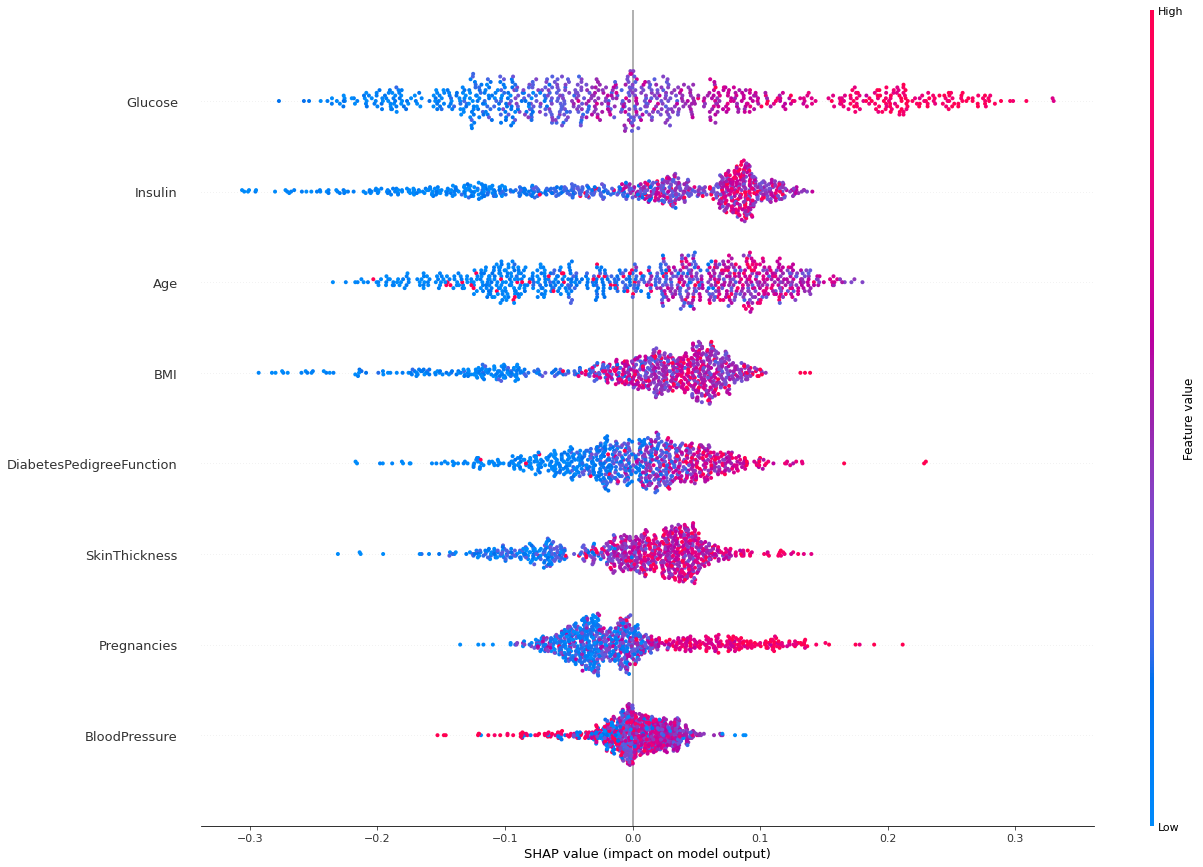

In [77]:
# Gráfico 1 - Contribução das variáveis
shap.summary_plot(shap_values_train[1], x_train, plot_type="dot", plot_size=(20,15));

### Avaliação do gráfico
Antes de avaliar o que este gráfico quer nos dizer sobre o nosso problema, precisamos entender cada característica nele presente:
- O eixo Y são as variáveis do nosso modelo em ordem de importância (o SHAP ordena isso de forma padrão, você pode escolher outra ordem através dos parâmetros)
- O eixo X são os valores SHAP. Como a nossa referência é a categoria positiva então valores positivos indicam um suporte para a categoria de referência (contribui pro modelo responder categoria positiva no final) e valores negativos indicam um suporte à categoria oposta (neste caso de classificação binária, seria a classe negativa)
- Cada ponto no gráfico representa uma amostra. Cada variável possui 800 pontos distribuídos horizontalmente (visto que temos 800 amostras, logo cada amostra tem um valor para aquela variável). Note que essas nuvens de pontos em algum momento se expande verticalmente. Isso ocorre dado a densidade de valores daquela variável em relação aos valores SHAP.
- Finalmente, as cores representam o aumento/diminuição do valor da variável, onde tons mais vermelhos são valores altos e tons azulados são valores mais baixos.

De forma geral, iremos buscar variáveis que:
- Tenham uma divisão bem clara de cores, ou seja, vermelho e azul em lugares opostos. Essa informação mostra que elas são boas preditoras, afinal apenas ao mudar seu valor o modelo consegue verificar de forma mais fácil qual categoria é a correta.
- Associado a isso, quanto maior o intervalo de alcance de valores SHAP, melhor será aquela variável para o modelo. Vamos considerar **Glucose**, que apresenta em algumas situações valores de SHAP em torno de 0,3, ou seja, 30% de contribuição para o resultado do modelo (isso porque o máximo que qualquer variável pode atingir é 50%).

A variável **Glucose** e **Insulin** apresenta essas duas características mencionadas. Agora note a variável **BloodPressure**: No geral, ela é uma variável confusa visto que seus valores SHAP ficam em torno de 0 (contribuições fracas) e com uma clara mistura de cores, visto que você não consegue ver uma tendência do aumento/diminuição dessa variável na resposta final.

Vale destacar também a variável **Pregnancies** que não possui um intervalo tão grande como **Glucose**, porém demonstra uma divisão clara de cores.

**Por meio desse gráfico, você consegue tirar um panorama geral de como seu modelo chega a suas conclusões a partir do conjunto de treinamento**.

O gráfico seguinte mostra uma contribuição média do gráfico que apresentamos anteriormente:

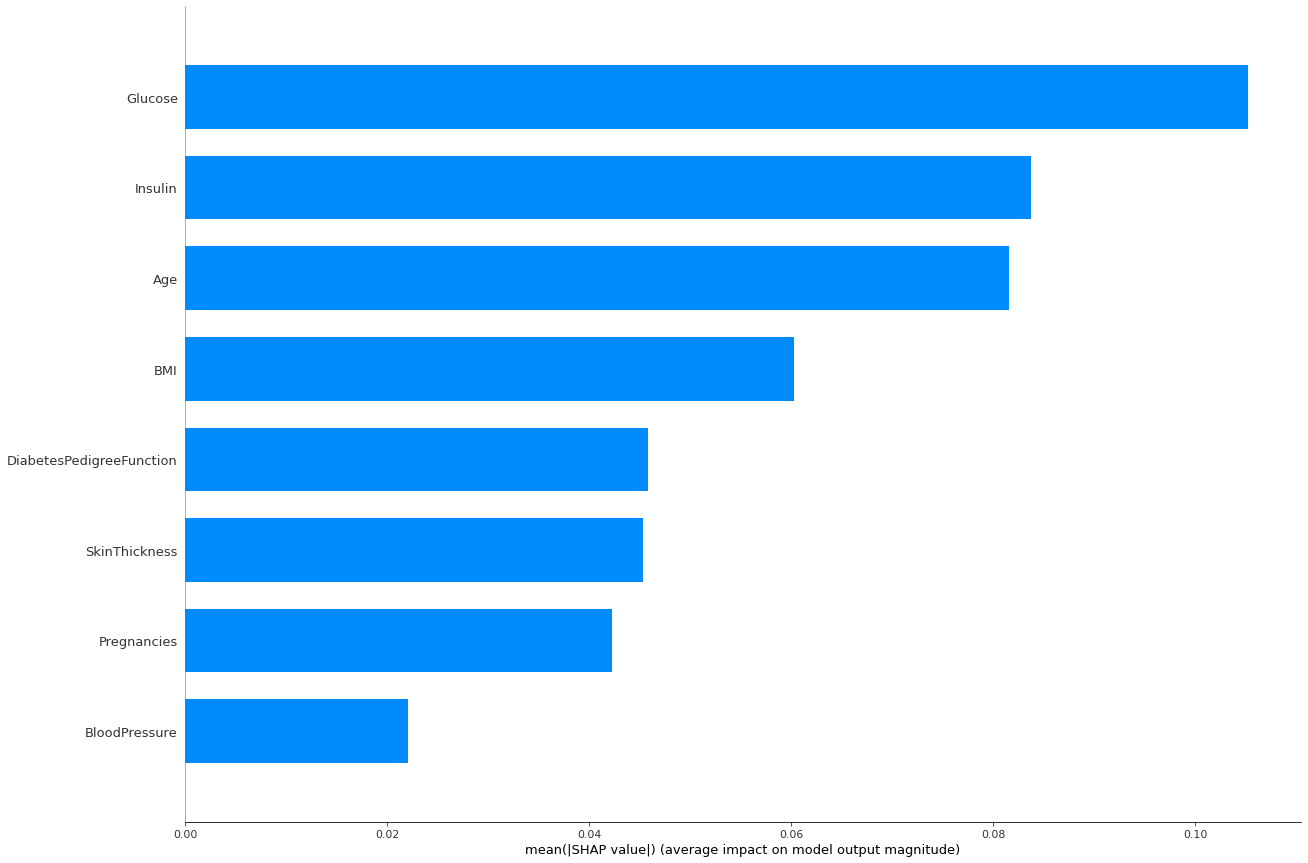

In [78]:
# Gráfico 2 - Contribução de Importância das variáveis
shap.summary_plot(shap_values_train[1], x_train, plot_type="bar", plot_size=(20,15));

### Avaliação do gráfico
Basicamente como o próprio título do eixo X demonstra, cada barra representa a média dos valores SHAP em módulo, assim avaliamos a contribuição média das variáveis nas respostas do modelo. Considerando a **Glucose**, vemos que sua contribuição média gira em torno de 12% para a categoria positiva.

Este gráfico pode ser feito em relação a qualquer uma das categorias (optei pela positiva) ou em relação à ambas. Ela configura como um ótimo gráfico para substituir o primeiro em explicações para gestores ou pessoas mais ligadas na área de negócio dado sua simplicidade.

## Interpretação de predição da amostra
Além de visualizações gerais, o SHAP proporciona análises mais individuais por amostras. Gráficos como esses são interessantes para apresentar algum resultado em especial. 

Por exemplo digamos que esteja trabalhando em um problema de churn de clientes e você quer mostrar como seu modelo compreendeu a saída do maior cliente de sua companhia. Através dos gráficos que serão apresentados aqui, você consegue mostrar em uma apresentação de forma bem didática o que aconteceu através do Machine Learning e discutir sobre aquele case.

O primeiro gráfico a ser mostrar é o Waterfall em relação a categoria positiva:

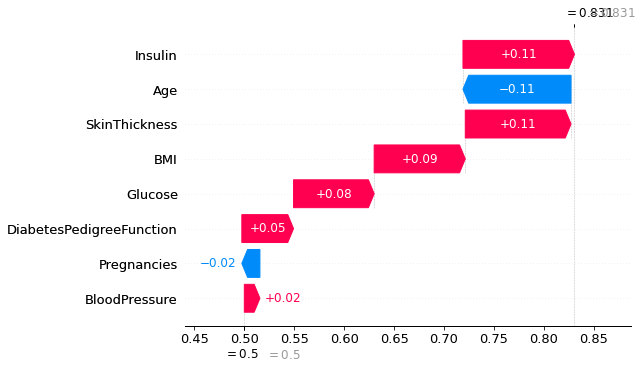

In [79]:
# Gráfico 3 - Impacto das variáveis em uma predição específica do modelo versão Waterfall Plot
shap.plots._waterfall.waterfall_legacy(expected_value=expected_value[1], shap_values=shap_values_train[1][3].reshape(-1), feature_names=x_train.columns, show=True)

### Avaliação do gráfico
Neste gráfico, você consegue ver que sua predição parte debaixo para cima a partir do valor de base. Cada variável contribui de forma positiva (modelo prever categoria positiva) e de forma negativa (modelo prever outra classe). Neste exemplo vemos por exemplo que a contribuição de **SkinThickness** é anulada pela **Age**.

Ainda neste gráfico, o eixo X representa os valores de SHAP e os valores das setas indicam as contribuições dessas variáveis.

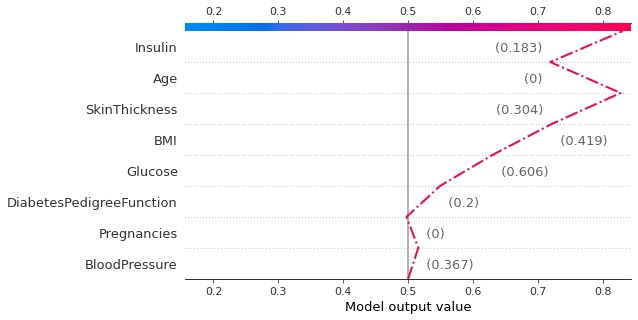

In [80]:
# Gráfico 4 - Impacto das variáveis em uma predição específica do modelo versão Line Plot
shap.decision_plot(base_value=expected_value[1], shap_values=shap_values_train[1][3], features=x_train.iloc[3,:],highlight=0)

### Avaliação do gráfico
Este gráfico é equivalente ao anterior. Como nossa categoria de referência é a positiva, o resultado do modelo seguir para tons mais avermelhados (na direita) indica uma predição para classe positiva e para a esquerda, uma predição para a classe negativa.

Neste gráfico, os valores próximos da seta indicam os valores das variáveis (referente a amostra) e não aos valores SHAP.

# Interpretação de Modelo II - *Partial Dependence Plots*
Apesar de estar contido no pacote do SHAP, esta técnica é independente desta teoria. Porém, sua visualização está bem estabelecida dentro deste pacote.

**Partial Dependence Plots** (PDP) são uma forma de você avaliar o impacto da resposta do modelo a partir da variação de duas variáveis. Nesta modalidade, você deixa de avaliar apenas as variáveis de forma separadas como foi visto anteriormente e consegue verificar relações em pares.

Análises como essas são interessantes quando você analisa problemas que possuem um domínio técnico muito forte.

Por exemplo, considere um modelo que no seu conjunto de variáveis tenha o preço e a demanda de determinado produto, é de se esperar que exista algum tipo de relação entre essas variáveis e esse tipo de relação consegue ser avaliado por meio de PDPs.

No gráfico abaixo, vamos avaliar a relação entre as duas variáveis mais importantes do modelo usando com referência a categoria positiva:

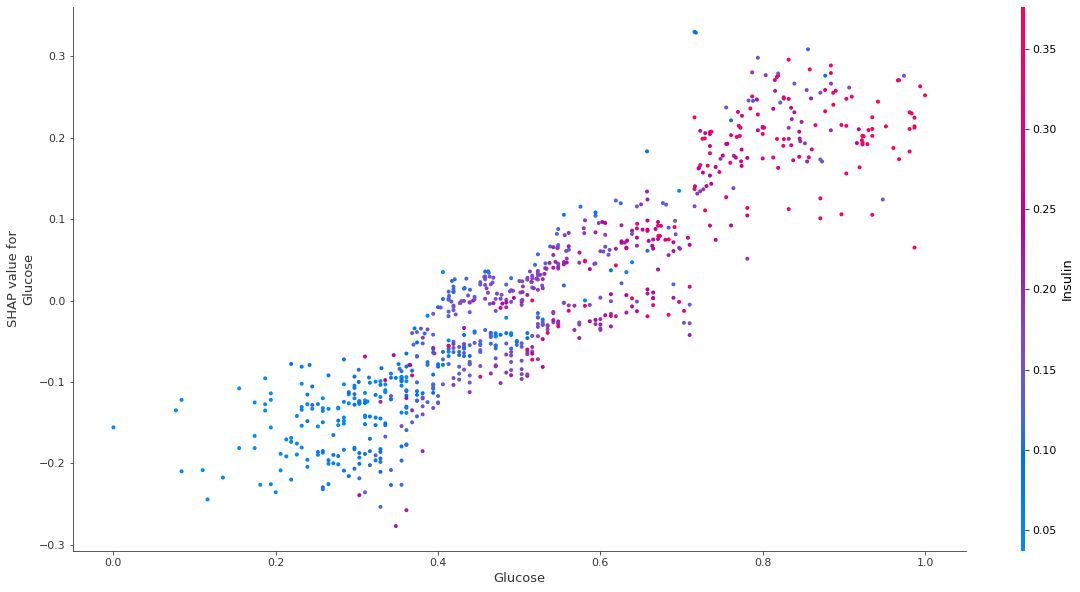

In [81]:
# Gráfico 2 - Gráfico de Dependência
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
shap.dependence_plot('Glucose', shap_values_train[1], x_train.values, feature_names=x_train.columns, interaction_index='Insulin', ax=ax)

### Avaliação do gráfico
Antes de analisar este gráfico, precisamos entender suas características:
- O eixo X são os valores da variável **Glucose**
- O eixo Y são os valores SHAP calculados para variável **Glucose**
- As cores dos pontos são os valores da segunda variável: **Insulin**. Note novamente que da cada ponto representa uma amostra, totalizando assim 800 pontos no gráfico.

De início conseguimos perceber uma certa tendência linear: a medida que a variável **Glucose** aumenta, os valores SHAP aumentam também. Cores mais avermelhadas (indicam maiores valores de **Insulin**), logo conseguimos perceber que relações onde temos alto valor de **Glucose** e **Insulin** podem indicar uma maior probabilidade do modelo responder como categoria positiva. Este tipo de resultado é bem interessante de encontrar. 

Como estamos avaliando um modelo com base médica, relações como essas podem ser validadas na litetura médica e fortalecer ainda mais a confiança no seu modelo.


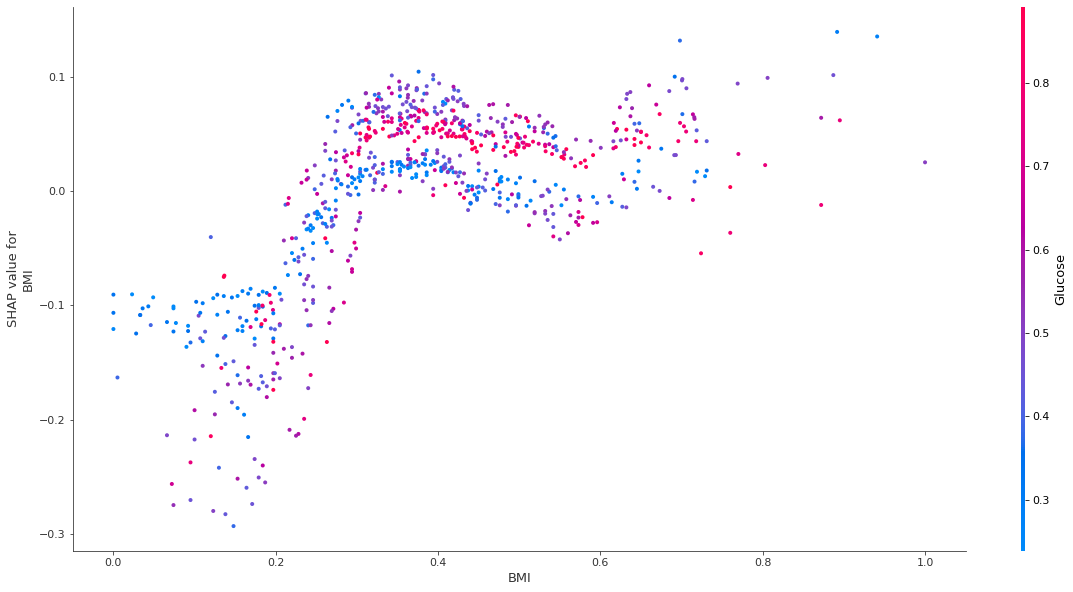

In [82]:
# Gráfico 2 - Gráfico de Dependência
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
shap.dependence_plot('BMI', shap_values_train[1], x_train.values, feature_names=x_train.columns, interaction_index='Glucose', ax=ax)

### Avaliação do gráfico
Já neste caso, vemos inicialmente a relação entre os valores SHAP e a variável **BMI** apresenta uma curvatura em S, diferente da relação linear que achamos anteriormente. Além disso, valores maiores de **Glucose** se concentram mais na parte do superior do gráfico com valores maiores de SHAP.

Visualizações como essa podem gerar outros resultados como: **A correlação dos valores SHAP VS os valores da variável pode ser significante?** Assim encontraríamos por exemplo uma clara correlação simples entre o resultado do modelo e o valor da variável.

# Interpretação de Modelo III - Permutation Importance
Este método busca avaliar a importância das variáveis no resultado do modelo em relação à alguma métrica. Ou seja, diferente dos métodos anteriores onde avaliavamos a **resposta do modelo**, com este método avaliamos o **desempenho do modelo**.

Sua ideia é bem simples: entender a importância daquela variável em uma métrica de desempenho quando a mesma não está presente. Porém, nos modelos que não conhecemos isso não é possível, afinal para fazer uma predição como uma regressão logística ou XGBoost, vamos precisar de uma amostra completa sem valor faltante. Em vista disso, podemos fazer o seguinte:
- Treinar o modelo sem a variável X
- Avaliar o resultado do modelo em relação a métrica
- Calcular a importância

Porém, isso não é uma boa técnica: é algo caro computacionalmente e nada garante que não estamos fazendo essa análise em relação aquele o conjunto de teste e não generalizando.

Sem mais rodeios, a **Permutation Importance** é feita inserindo ruído em uma variável X e calculando sua importância. Para funcionar esse método, você pode adicionar ruídos extraídos de uma distribuição equivalente ao da variável OU embaralhar os valores daquela variável. Por exemplo, para a amostra 5 vamos utilizar o valor da variável X da amostra 10. Assim conseguimos verificar com qualidade a importância daquela variável. A imagem abaixo exemplifica o que acontece:
![PI](https://user-images.githubusercontent.com/32513366/112769785-4e680280-8ff9-11eb-99fd-c79fcee7b61d.png)

Em resumo você bagunça os valores da variável que você quer medir.

In [83]:
# Calcular importância de permutação para conjunto de teste
model_pi = eli5.sklearn.PermutationImportance(model, scoring='roc_auc', random_state=1206).fit(x_test, y_test)

# Apresentar resultados para o conjunto de teste
eli5.show_weights(model_pi, feature_names =x_test.columns.tolist())

Weight,Feature
0.0909 ± 0.0487,Glucose
0.0534 ± 0.0056,BMI
0.0294 ± 0.0279,Age
0.0274 ± 0.0168,Insulin
0.0160 ± 0.0184,DiabetesPedigreeFunction
-0.0034 ± 0.0247,SkinThickness
-0.0084 ± 0.0095,Pregnancies
-0.0136 ± 0.0009,BloodPressure


### Avaliação do resultado
O resultado apresentado mostra duas colunas: **Weight** (Impacto da variável no desempenho) e **Feature** (Nome da coluna). As variáveis estão ordenadas de acordo a importância dela, logo as variáveis do topo foram as mais impactantes no desempenho, e as debaixo as que menos importam.

O primeiro número em cada linha mostra o quanto o desempenho do modelo diminuiu com um embaralhamento aleatório. Como a maioria das coisas na ciência de dados, há alguma aleatoriedade na mudança exata de desempenho de uma coluna embaralhada. Medimos a quantidade de aleatoriedade em nosso cálculo de importância de permutação repetindo o processo com embaralhamento. O número após ± mede como o desempenho variou de uma remodelação para a próxima.

Ocasionalmente, você verá valores negativos para importâncias de permutação como no caso os valores de **SkinThickness**, **Pregnancies**, **BloodPressure**. Nesses casos, as previsões sobre os dados embaralhados (ou ruidosos) eram mais precisas do que os dados reais. 

Isso acontece quando a variável não importava (deveria ter uma importância próxima a 0), mas a chance aleatória fazia com que as previsões nos dados embaralhados fossem mais precisas.

# Interpretação de Modelo IV - LIME
O LIME funciona de forma equivalente ao SHAP, ou seja, possui a mesma função e por isso não irei explorar tanto.

Para quem fez Engenharia de Controle e Automação ou Elétrica, vai entender como funciona a ideia por trás deste método: Ele assume que a predição em um nível local consegue ser aproximada por um modelo linear (regressão linear), assim com uma análise local (e não global como é feito no SHAP) você consegue explicar qualquer modelo, sendo assim um método agnóstico.

Esse conceito é bem parecido com a linearização usada em análise de sistemas.

Para utilizar esse método, usei a biblioteca `lime` construída pelos autores do paper que o originou (inclusive, o autor principal é brasileiro).

Neste exemplo, definimos a instância do LIME e então calculamos a explicação para uma amostra em específico:

In [84]:
# Definindo XAI do modelo com LIME
explainer_lime = lime.lime_tabular.LimeTabularExplainer(training_data=x_train.values, 
                                                        feature_names=list(x_train.columns),
                                                        class_names=['Sem Diabetes', 'Com Diabetes'],
                                                        discretize_continuous=False,
                                                        random_state=1206)

In [85]:
# Calculando LIME
explained_sample = explainer_lime.explain_instance(x_train.values[3], model.predict_proba)

Abaixo apresentamos o resultado encontrado pelo LIME para a amostra 3:

In [86]:
# Mostrando o resultado final
explained_sample.show_in_notebook(show_table=True, show_all=False)

### Avaliação do resultado
A esquerda você encontra as probabilidades de predição e na extrema direita os valores da amostra para cada variável. No meio está a magia do LIME: O impacto de cada variável por ordem de grandeza no resultado final.

Para ter mais informações sobre o método recomendo acessar fortemente esta publicação do [medium](https://towardsdatascience.com/understanding-model-predictions-with-lime-a582fdff3a3b) ou acessar o repositório [aqui](https://github.com/marcotcr/lime).

Como este método tem poucas opções em comparação ao SHAP, acredito que não vale a pena me estender neste momento.

# Extra - Situações de "What if Analysis"

**What If Analysis** são estudos mais aprofundados de situações "E se...".

Se mantermos todas as variáveis com o mesmo valor e alterarmos uma delas, como o modelo irá responder aquele resultado?

Vamos usar a amostra 3 para verificar um cenário onde modificamos a variável mais importante Glucose:

In [87]:
# Amostra definida - 83% de certeza de ser positivo
sample = x_train.iloc[3,:].copy()

# 1 - Predição original
print('Probabilidade original de apresentar diabetes - ', 100*round(model.predict_proba(np.array(sample).reshape(1, -1))[0, 1] ,2), '%.')

# 2 - Aumentando o valor de glucose, qual será a porcentagem?
sample['Glucose'] = sample['Glucose'] + (sample['Glucose']/2)
print('Probabilidade com aumento de glucose de apresentar diabetes - ', 100*round(model.predict_proba(np.array(sample).reshape(1, -1))[0, 1] ,2), '%.')

# 3 - Diminuindo o valor de glucose drasticamente, qual será a porcentagem?
sample = x_train.iloc[3,:].copy()
sample['Glucose'] = sample['Glucose'] - (sample['Glucose']/2)
print('Probabilidade com diminuição de glucose de apresentar diabetes - ', 100*round(model.predict_proba(np.array(sample).reshape(1, -1))[0, 1] ,2), '%.')

Probabilidade original de apresentar diabetes -  83.0 %.
Probabilidade com aumento de glucose de apresentar diabetes -  93.0 %.
Probabilidade com diminuição de glucose de apresentar diabetes -  41.0 %.


### Avaliação de resultado
Note que adicionando metade do valor da glucose, aumentamos a probabilidade para 93%, aumentando assim a confiança do modelo naquela resposta. Porém ao remover metade do valor da Glucose, o modelo perde toda confiança na classe positiva e responde a classe negativa como correta com 61%.

# Interpretação Gráfica I - PCA

Diferentes dos métodos passados anteriormente, PCA é um método de redução de dimensionalidade, ou seja, reduzir seu conjunto de variáveis. Não irei entrar em detalhes matemáticos de como funciona por debaixo dos panos o algoritmo de PCA, para saber mais recomendo fortemente este vídeo do [StatsQuest](https://www.youtube.com/watch?v=FgakZw6K1QQ) em inglês ou este [vídeo por Leandro Souto](https://www.youtube.com/watch?v=KqZAC4jyJKc) para entender mais. A PCA pode ser usada para lidar com conjuntos com muitas correlações entre suas variáveis, visto que os componentes principais gerados pelo método não apresentam essa característica! Vale lembrar que vários modelos de ML sofrem de alguma forma com variáveis correlacionadas.

Aqui irei apresentar uma utilização diferente da mais utilizada para este método: **construção de mapas explicáveis do seu conjunto de variáveis em relação a sua variável objetivo**.

Vamos entender isso mais para frente, agora vamos preparar a PCA:

In [88]:
# Construir um objeto para realizar a PCA
pca_obj = prince.PCA(n_components=len(x_train), random_state=1206, n_iter=100, engine='sklearn')

# Aplicar a PCA
pcs = pca_obj.fit_transform(x_train)

Ao realizar a PCA em conjunto de 8 variáveis, geramos 8 componentes principais independentes construidos linearmente através do conjunto original.

In [89]:
# Construir variação explicada aculumada
inertial_explained = 100*pca_obj.explained_inertia_.round(4)

# Definindo a lista acumulada
inertial_expl_acc = [inertial_explained[0]]

# Conseguindo os valores acumulados
for i in range(1, len(inertial_explained)):
    inertial_expl_acc.append(inertial_expl_acc[i-1] + inertial_explained[i])

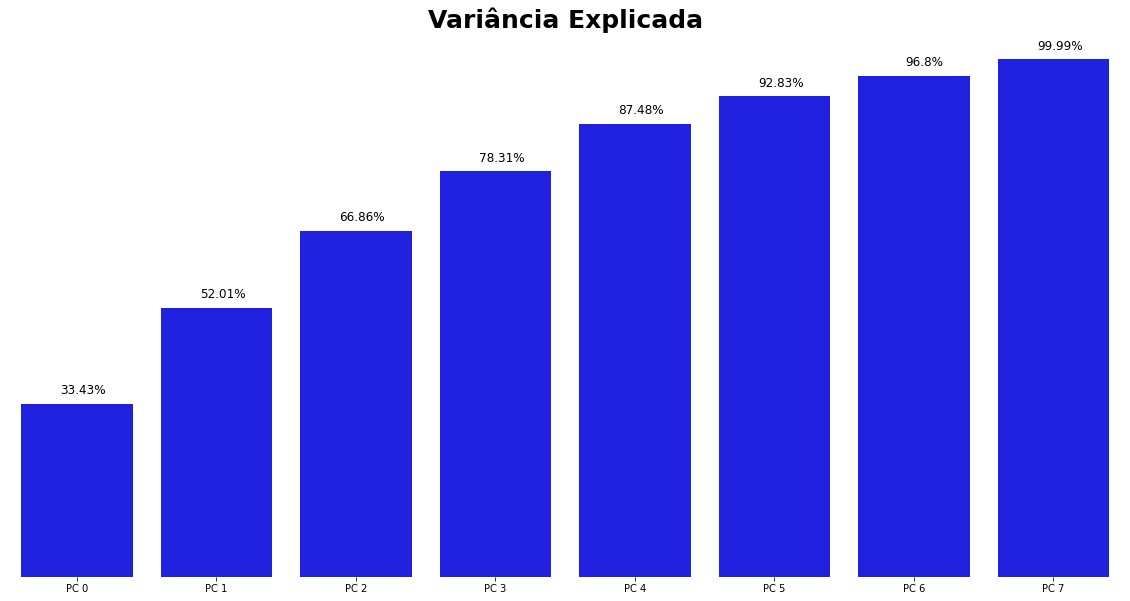

In [90]:
# Definir tamanho da figura
plt.figure(figsize=(20,10));
# Realizar grafico
ax = sns.barplot(x=['PC '+ str(i) for i in range(0, len(inertial_explained))], y=inertial_expl_acc, color='blue');
# Aplicar configuracoes esteticas no grafico
plt.ylabel('');
plt.yticks([]);
ax.set_title('Variância Explicada', fontsize=25, weight='bold');
ax.spines['top'].set_visible(False);
ax.spines['left'].set_visible(False);
ax.spines['right'].set_visible(False);
ax.spines['bottom'].set_visible(False);
annotate_bars_value(ax, (85,10), barra_eixo_y=False);

### Avaliação do gráfico
Este gráfico antes de mais nada mostra a **variância explicada** do seu conjunto de treino pelos componentes principais gerados através da PCA. Através dele você consegue perceber que as primeiras componentes possuem uma explicabilidade maior em comparação aos últimos. Isso ocorre, pois na PCA existe um ranqueamento, logo o componente principal 0 possuirá uma explicabilidade maior que o 1 e assim vai...

Por meio desse gráfico você consegue ter uma ideia da explicabilidade do seu conjunto inicial com N variáveis para um conjunto construído a partir dela com uma quantidade menor.

Para para construir nosso mapa, iremos trabalhar com os dois primeiros componentes principais que possuem junto uma explicabilidade de 52% da variância do conjunto original. Iremos utiliza-los como eixos de um mapa 2D

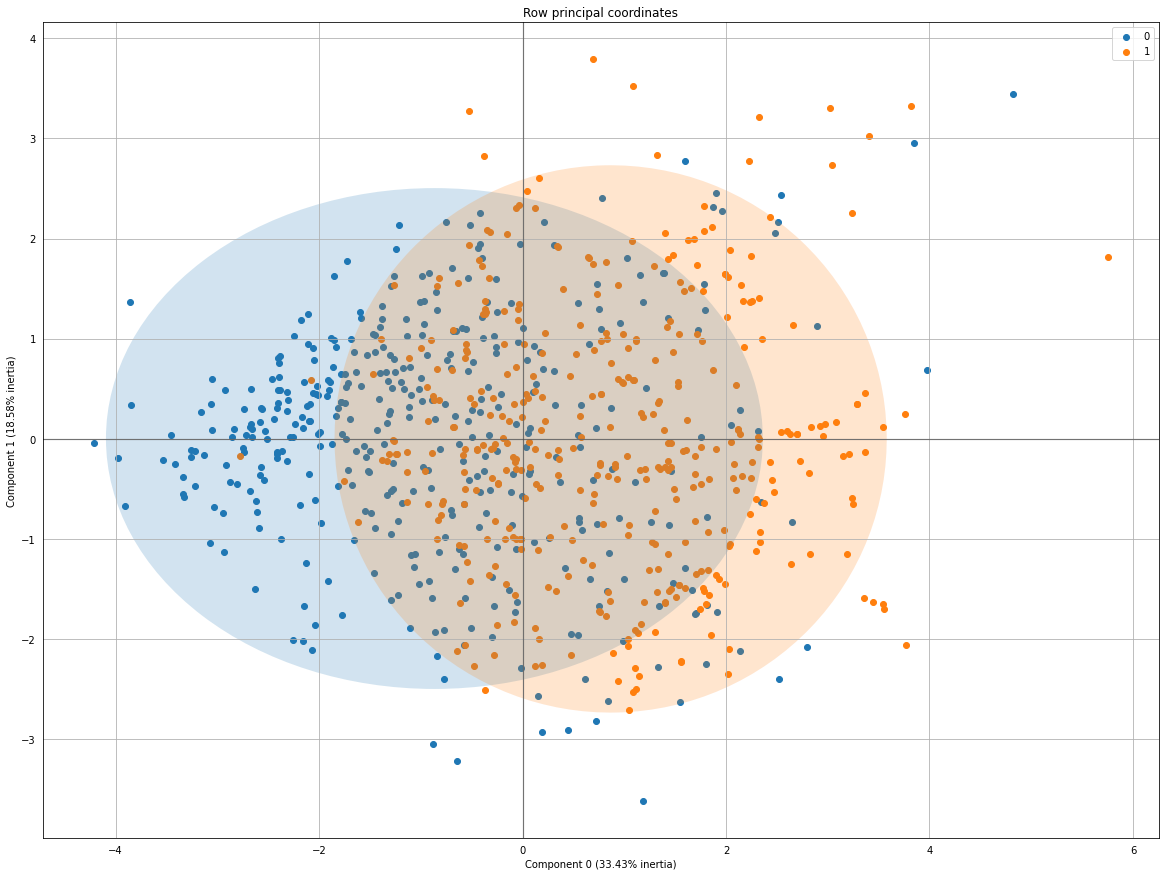

In [91]:
# Visualizando o espaço transformado da PCA
pca_obj.plot_row_coordinates(x_train, figsize=(20, 15), x_component=0, y_component=1, color_labels=y_train);

### Avaliação do gráfico
O gráfico apresentado é um mapa gerado através de uma transformação do nosso conjunto de treinamento segmentado por nossa variável objetivo (aquela que usamos para classficar). 

Seu resultado não é ideal, visto que existe uma grande intersecção entre ambos os dois conjuntos. O resultado ideal seria aquele onde ambos os grupos estivessem distantes. Resultados como o ideal podem identificar que de fato seu grupo de features é capaz de identificar bem aquela sua variável objetivo.

Além disso, fica muito mais fácil convencer em algum projeto de DS utilizando visualizações como essa, pois o resultado estaria claro o que favoreceria sua narrativa.

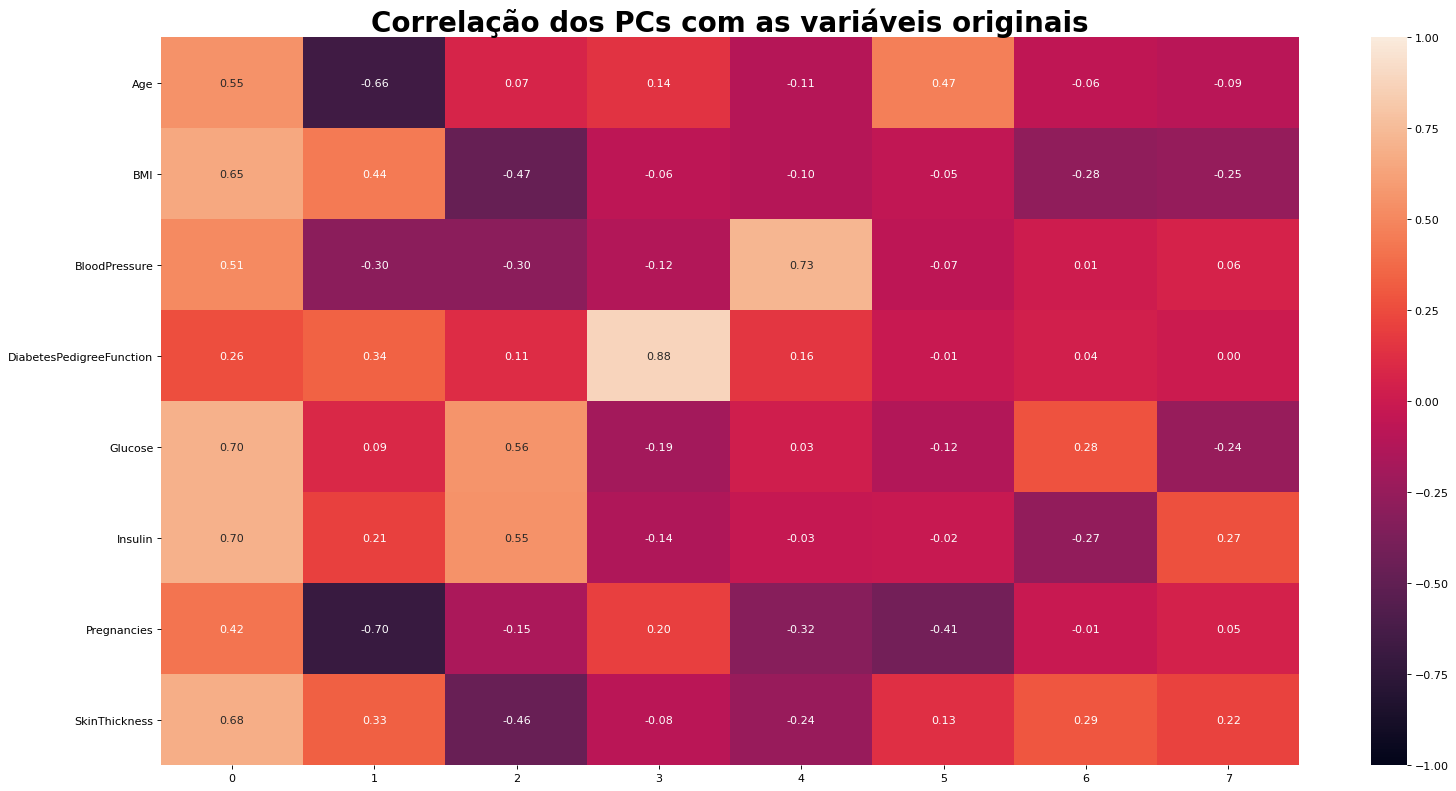

In [92]:
# Calcular correlacao
pca_corr = pca_obj.column_correlations(x_train)

# Correlação das variáveis com os componentes principais
plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(pca_corr, annot = True, fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlação dos PCs com as variáveis originais', fontsize=25, fontweight='bold')
plt.tight_layout()

### Avaliação do resultado
Finalmente, este gráfico final mostra a correlação entre as variáveis do conjunto original e os componentes principais. Por ser um método linear, você consegue avaliar o peso de cada variável em cada componente e assim conseguir explicar o resultado do mapa anterior. 

Um exemplo seria a variável `DiabetesPedigreeFunction` que contribuiu fortemente para a construção do PC3.

# Conclusão
Este notebook tem o intuito de trazer mais conteúdo para a língua portuguesa sobre a área de Ciência de dados. 

Caso tenha ajudo dá um UP Vote!

Recomendo fortemente a leitura das referências...

## Referências de leitura/estudo
- [Canal Stats Quest - Muito conteúdo explicativo de DS](https://www.youtube.com/watch?v=FgakZw6K1QQ)
- [Documentação SHAP - Muito explicativo e principalmente com novas ideias de gráficos para utilizar](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html#linear_regression)
- [Documentação Permutation Importance](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html)
- [Tutorial Kaggle XAI](https://www.kaggle.com/learn/machine-learning-explainability)